In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
import glob

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# Generatorの実装

In [4]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=4),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


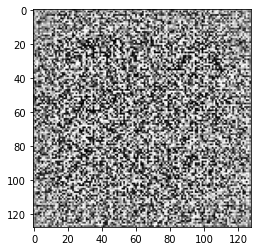

16384


In [5]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 入力する乱数
input_z = torch.randn(1, 20)

# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

print(img_transformed.size)


# Discriminatorの実装

In [6]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=4),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


In [7]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像をDに入力
d_out = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))


tensor([[[[0.5039]]]], grad_fn=<SigmoidBackward>)


# DataLoaderの作成

In [8]:
def make_datapath_list1():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """
    #cutoffなしの場合
    #pathは各自で作成する必要あり。
    files = glob.glob("./../data/distmap128_30nocut/*")
    train_img_list = files

    return train_img_list

In [9]:
def make_datapath_list2():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """
    #cutoffを施した場合
    #pathは各自で作成する必要あり。
    files = glob.glob("./../data/distmap128_30/*")
    train_img_list = files

    return train_img_list

In [10]:
class ImageTransform():
    #画像の前処理クラス

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [11]:
class GAN_Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        #画像の枚数を返す
        return len(self.file_list)

    def __getitem__(self, index):
        #前処理をした画像のTensor形式のデータを取得

        img_path = self.file_list[index]
        img = np.load(img_path)

        # 画像の前処理
        img_transformed = self.transform(img)
        img_transformed = img_transformed.to(torch.float32)

        return img_transformed

In [12]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list=make_datapath_list1()

# Datasetを作成
'''各データセットに合わせてmeanとstdを設定する。
基本的にはcutoffありで10,10、cutoffなしで21.5,21.5'''
mean = (21.5)
std = (21.5)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])



torch.Size([64, 1, 128, 128])


# 学習させる

In [13]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


In [14]:
# モデルを学習させる関数を作成
box = []

def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            label_real = label_real.type_as(d_out_real.view(-1))
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            label_fake = label_fake.type_as(d_out_fake.view(-1))
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        b = [epoch_d_loss, epoch_g_loss]
        box.append(b)

    return G, D


# 学習・検証を実行する

In [27]:
num_epochs = 50
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 0/10
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:5.4144 ||Epoch_G_Loss:231.8146
timer:  39.1294 sec.
-------------
Epoch 1/10
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:8.9182 ||Epoch_G_Loss:291.4089
timer:  39.4570 sec.
-------------
Epoch 2/10
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:6.2868 ||Epoch_G_Loss:260.5697
timer:  39.5996 sec.
-------------
Epoch 3/10
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:8.1321 ||Epoch_G_Loss:284.4465
timer:  39.7132 sec.
-------------
Epoch 4/10
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:7.7465 ||Epoch_G_Loss:288.9791
timer:  39.8421 sec.
-------------
Epoch 5/10
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:5.8977 ||Epoch_G_Loss:269.6021
timer:  39.8351 sec.
-------------
Epoch 6/10
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:9.9370 ||Epoch_G_Loss:341.2511
timer:  39.8805 sec.
-------------
Epoch 7/10
-

# 生成画像と訓練データを可視化する

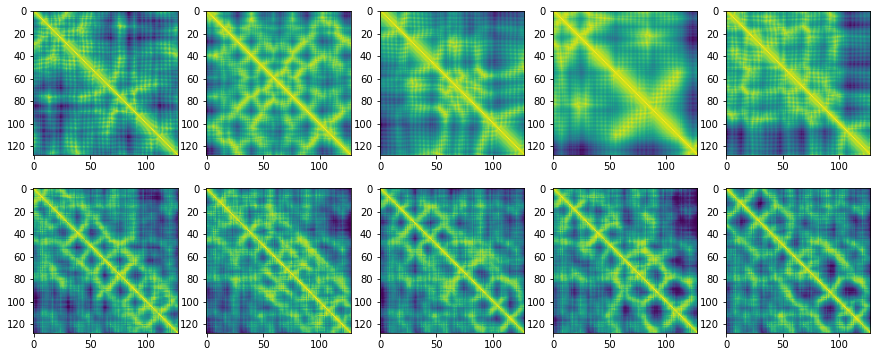

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(-imges[i][0].cpu().detach().numpy())

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(-fake_images[i][0].cpu().detach().numpy())
    #plt.savefig('./result/.png')

(128, 128)
[[-0.98532754 -0.7102512  -0.7283387  ...  0.23500468  0.30530345
   0.36313272]
 [-0.7581305  -0.98681813 -0.8009405  ...  0.38856912  0.4903539
   0.53902113]
 [-0.6689739  -0.70833784 -0.9925196  ...  0.160414    0.39980057
   0.40133426]
 ...
 [ 0.6104497   0.57833946  0.62408924 ... -0.9566902  -0.6413655
  -0.60115755]
 [ 0.78398883  0.66945606  0.7322264  ... -0.64297986 -0.97456086
  -0.7222783 ]
 [ 0.7391936   0.7508356   0.7084477  ... -0.5271603  -0.78999245
  -0.95863473]]


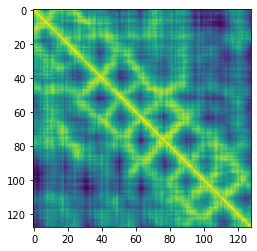

In [29]:
"""生成した画像を./data/sample.npyとして保存する"""
plt.imshow(-fake_images[0][0].cpu().detach().numpy())
im = fake_images[0][0].cpu().detach().numpy()
print(im.shape)
print(im)
#np.save("./data/sample", im)


In [30]:
#box内に損失の情報が入っている。
print(len(box))

50


In [31]:
print(len(box))
y1 = []
y2 = []
epoch = 50
"""↑この数字をepochの合計(box)の数に合わせる。"""
for i in range(epoch):
    y1.append(box[i][0])
    y2.append(box[i][1])
x = list(range(epoch))

50


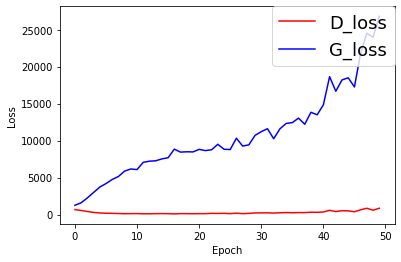

In [32]:
"""損失を表示"""
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, y1, "red", label="D_loss")
plt.plot(x, y2, "blue", label="G_loss")
#plt.title("1000_data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18)
#plt.savefig('./result/loss.png')